In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.emulator import parameter, DEFAULT_PARAMS as PARAMS

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [4]:
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [5]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [6]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [7]:
print em_params[y_param]

[ 11.7         11.96666667  12.23333333  12.5       ]


In [8]:
gbdt_hyperparams = {'n_estimators': int(1e3),
              'max_depth': 5}
gp_hyperparams = {}

In [9]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_rp'
training_dirs = ['/u/ki/swmclau2/des/PearceLHC_wp_rp','/u/ki/swmclau2/des/PearceLHC_wp_rp_dense',
                 '/u/ki/swmclau2/des/PearceFHC_wp_rp/']

truth_dir = '/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2/'

In [10]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu1 = OriginalRecipe(training_dir,method = 'gbdt',hyperparams=gbdt_hyperparams, params=or_params)
#emu1 = OriginalRecipe(training_dir,method = 'gp', params=or_params)

In [11]:
GOF_dict = {}
for method, hp, td in zip(['gp', 'gbdt', 'gbdt', 'svr'],\
                          [gp_hyperparams, gbdt_hyperparams, gbdt_hyperparams, {}],\
                          [training_dir, training_dir, training_dirs, training_dir]):
    print method
    emu = OriginalRecipe(td, method=method, hyperparams=hp, params=or_params)
    GOF = emu.goodness_of_fit(truth_dir)
    frac_err = emu.goodness_of_fit(truth_dir, statistic='log_frac')
    abs_err = emu.goodness_of_fit(truth_dir, statistic='log_abs')
    if method not in GOF_dict:
        GOF_dict[method] = (GOF, frac_err, abs_err)
    else:
        GOF_dict[method+' more training'] = (GOF, frac_err, abs_err)

gp
gbdt
gbdt
svr


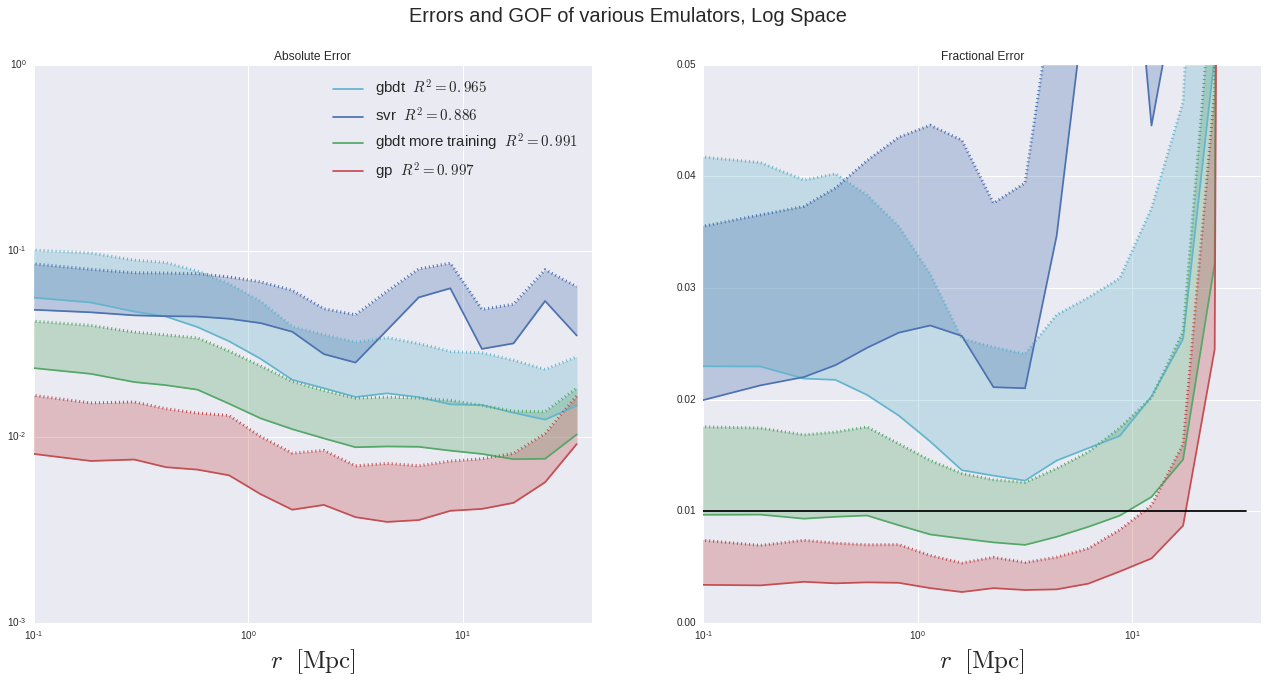

In [28]:
fig = plt.figure(figsize= (22,10))

for c, (method, (GOF, frac_errs, abs_errs) ) in zip(colors, GOF_dict.iteritems()):
    abs_mean = np.abs(abs_errs).mean(axis=0)
    abs_std = np.abs(abs_errs).std(axis=0)
    
    frac_mean = np.abs(frac_errs).mean(axis=0)
    frac_std = np.abs(frac_errs).std(axis=0)
    
    plt.subplot(121)
    #print abs_mean
    plt.plot(emu.bin_centers, abs_mean, label = method+r'  $R^2 = %.3f$'%GOF.mean() , color = c)
    plt.plot(emu.bin_centers, abs_mean+ abs_std, ls=':', lw = 3, color = c)
    #plt.plot(emu.bin_centers, abs_mean- abs_std, ls=':', lw = 3, color = c)
    plt.fill_between(emu.bin_centers,abs_mean,  abs_mean+ abs_std, alpha= 0.3,  color = c)
    
    plt.subplot(122)
    #print frac_mean
    #print
    plt.plot(emu.bin_centers, frac_mean, color = c)
    plt.plot(emu.bin_centers, frac_mean+frac_std, ls=':', lw =3, color = c)
    #plt.plot(emu.bin_centers, frac_mean-frac_std, ls=':', lw =3, color = c)
    plt.fill_between(emu.bin_centers, frac_mean, frac_mean+frac_std, color = c, alpha = 0.3)
    
plt.subplot(121)
plt.title('Absolute Error')
plt.xlim(xmin = 0.1, xmax = 40)
#plt.ylim(ymin = -1, ymax = 10)
#plt.loglog()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.legend(loc='best', fontsize = 15)

plt.subplot(122)
plt.title('Fractional Error')
plt.plot(emu.bin_centers, np.ones(len(emu.bin_centers))*0.01, color = 'k')
plt.xlim(xmin = 0.1, xmax = 40)
plt.ylim(ymin = 0, ymax = 0.05)
#plt.loglog()
plt.xscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
#plt.ylabel(r'Relative Error', fontsize = 25)

plt.suptitle('Errors and GOF of various Emulators, Log Space', fontsize = 20)
plt.show()

In [13]:
import cPickle as pickle
with open('GOF_dict.pkl', 'w') as f:
    pickle.dump(GOF_dict, f)

In [14]:
GOF_dict2 = {}
for method, hp, td in zip(['gp', 'gbdt', 'gbdt', 'svr'],\
                          [gp_hyperparams, gbdt_hyperparams, gbdt_hyperparams, {}],\
                          [training_dir, training_dir, training_dirs, training_dir]):
    print method
    emu = OriginalRecipe(td, method=method, hyperparams=hp, params=or_params)
    GOF = emu.goodness_of_fit(truth_dir)
    frac_err = emu.goodness_of_fit(truth_dir, statistic='frac')
    abs_err = emu.goodness_of_fit(truth_dir, statistic='abs')
    if method not in GOF_dict2:
        GOF_dict2[method] = (GOF, frac_err, abs_err)
    else:
        GOF_dict2[method+' more training'] = (GOF, frac_err, abs_err)

gp
gbdt
gbdt
svr


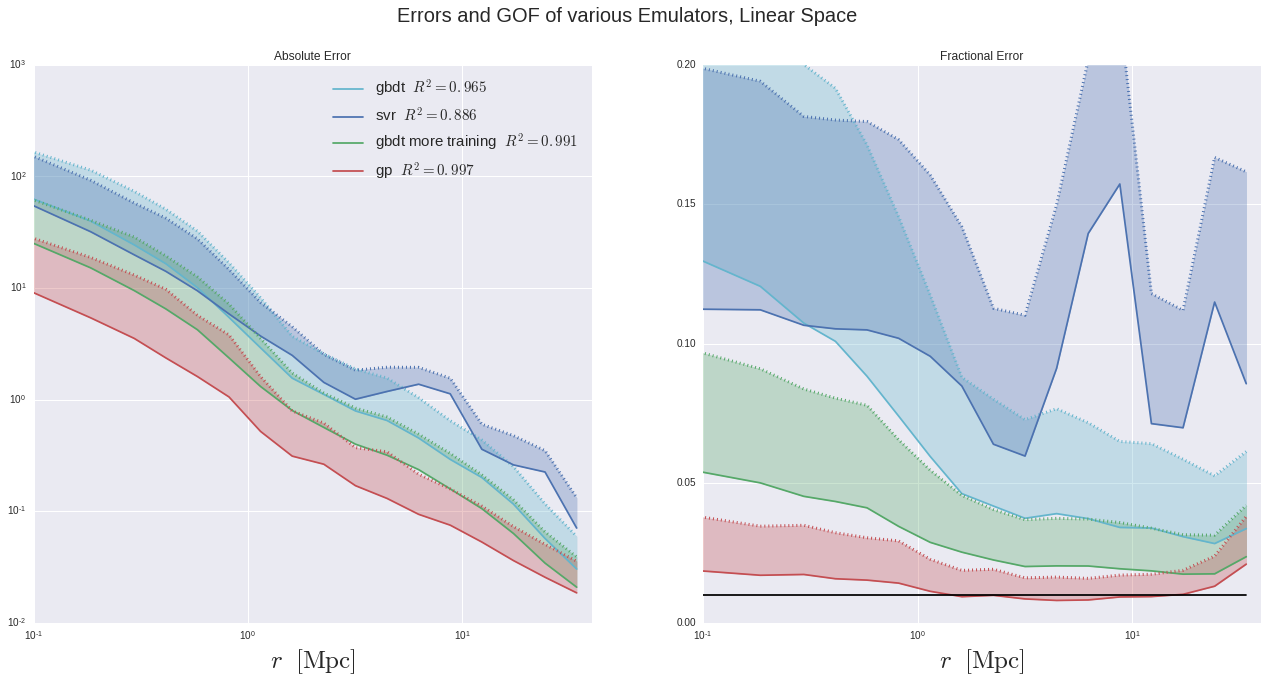

In [22]:
fig = plt.figure(figsize= (22,10))

for c, (method, (GOF, frac_errs, abs_errs) ) in zip(colors, GOF_dict2.iteritems()):
    abs_mean = np.abs(abs_errs).mean(axis=0)
    abs_std = np.abs(abs_errs).std(axis=0)
    
    frac_mean = np.abs(frac_errs).mean(axis=0)
    frac_std = np.abs(frac_errs).std(axis=0)
    
    plt.subplot(121)
    #print abs_mean
    plt.plot(emu.bin_centers, abs_mean, label = method+r'  $R^2 = %.3f$'%GOF.mean() , color = c)
    plt.plot(emu.bin_centers, abs_mean+ abs_std, ls=':', lw = 3, color = c)
    #plt.plot(emu.bin_centers, abs_mean- abs_std, ls=':', lw = 3, color = c)
    plt.fill_between(emu.bin_centers,abs_mean,  abs_mean+ abs_std, alpha= 0.3,  color = c)
    
    plt.subplot(122)
    #print frac_mean
    #print
    plt.plot(emu.bin_centers, frac_mean, color = c)
    plt.plot(emu.bin_centers, frac_mean+frac_std, ls=':', lw =3, color = c)
    #plt.plot(emu.bin_centers, frac_mean-frac_std, ls=':', lw =3, color = c)
    plt.fill_between(emu.bin_centers, frac_mean, frac_mean+frac_std, color = c, alpha = 0.3)
    
plt.subplot(121)
plt.title('Absolute Error')
plt.xlim(xmin = 0.1, xmax = 40)
#plt.ylim(ymin = -1, ymax = 10)
#plt.loglog()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.legend(loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(emu.bin_centers, np.ones(len(emu.bin_centers))*0.01, color = 'k')
plt.title('Fractional Error')
plt.xlim(xmin = 0.1, xmax = 40)
plt.ylim(ymin = 0, ymax =0.2)
#plt.loglog()
plt.xscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
#plt.ylabel(r'Relative Error', fontsize = 25)

plt.suptitle('Errors and GOF of various Emulators, Linear Space', fontsize = 20)
plt.show()

In [16]:
import cPickle as pickle
with open('GOF_dict2.pkl', 'w') as f:
    pickle.dump(GOF_dict, f)